In [1]:
import csv
import time

import alphashape
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from adaptive_swim.ansatz import BasicAnsatz
from swimpde.boundary import Dirichlet
from swimpde.domain import Domain
from swimpde.equation import Helmholtz
from swimpde.solver import StaticSolver
from copy import deepcopy

from utils import compute_metrics, filter_results

Parameters of the equation

In [2]:
def forcing(x: npt.ArrayLike):
    scales = np.array([1, 1, 4])
    sin_transforms = np.sin(np.pi * scales * x)
    u = 5 + np.prod(sin_transforms, axis=1)[:, None]
    u_xx = -18 * np.pi**2 * (u - 5)
    return u_xx - u

def solution(x: npt.ArrayLike) -> npt.ArrayLike:
    scales = np.array([1, 1, 4])
    sin_transforms = np.sin(np.pi * scales * x)
    return 5 + np.prod(sin_transforms, axis=1)[:, None]

boundary_condition = Dirichlet(solution)

Load the data

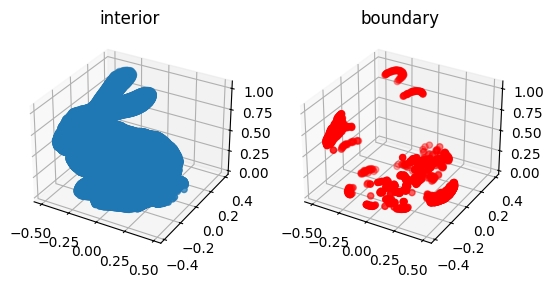

In [3]:
# Load the bunny points.
with open('data/bunny_vertices.csv') as fin:
    csvreader = csv.reader(fin)
    bunny_points = np.array(list(csvreader)).astype(float)

# Create alpha shape
alpha = 1e-4
alpha_shape = alphashape.alphashape(bunny_points, alpha)

# shape: (n_points, n_vertices)
vertices_mask = np.all(bunny_points[:, None, :] ==
                       alpha_shape.vertices[None, :, :],
                       axis=-1)
if (np.any(vertices_mask.sum(axis=0) != 1) or
    np.any(vertices_mask.sum(axis=1) > 1)):
    raise ValueError("Something went wrong with the mask.")

boundary_mask = np.any(vertices_mask, axis=1)
interior_points = bunny_points[~boundary_mask]
boundary_points = bunny_points[boundary_mask]

# Visualize the data
fig = plt.figure()
ax_int = fig.add_subplot(121, projection='3d')
ax_int.scatter(*interior_points.T)
ax_int.set_title("interior")

ax_bound = fig.add_subplot(122, projection='3d')
ax_bound.scatter(*boundary_points.T, c='r')
ax_bound.set_title("boundary");

Create a train/test split

In [4]:
rng = np.random.default_rng(42)
train_fraction = 0.7

def get_train_mask(rng: np.random.Generator,
                   n_points: int,
                   train_fraction: float):
    mask = np.zeros(n_points).astype(bool)
    train_indices = rng.choice(n_points,
                               size=int(n_points*train_fraction),
                               replace=False)
    mask[train_indices] = True
    return mask
    
interior_train_mask = get_train_mask(rng,
                                     interior_points.shape[0],
                                     train_fraction)
boundary_train_mask = get_train_mask(rng,
                                     boundary_points.shape[0],
                                     train_fraction)

train_interior = interior_points[interior_train_mask]
test_interior = interior_points[~interior_train_mask]
train_boundary = boundary_points[boundary_train_mask]
test_boundary = boundary_points[~boundary_train_mask]

Create data for evaluation

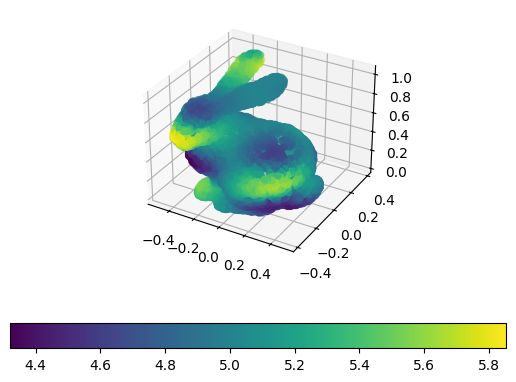

In [5]:
x_eval = np.concatenate([test_interior, test_boundary])
u_exact = solution(x_eval)

# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
eval_plot = ax.scatter(*x_eval.T, c=u_exact)
fig.colorbar(eval_plot, ax=ax, location='bottom')

# Create the domain
domain = Domain(interior_points=train_interior,
                boundary_points=train_boundary)

Solve the equation

In [2]:
# Parameters of the solver 
activations = ["tanh", "a_tanh", "rational"]
n_bases = [500, 1000, 2000, 4000, 8000]
s_list = [0.5]
k_list = [5, 10, 20, 40]
seeds = [1, 2, 3]
svd_cutoff = 1e-12
regularization_scale = 1e-12
rtol = 1e-10 # relative tolerance for ODE solver
atol = 1e-10

In [7]:
# A target for the basis functions.
# (target functions that already satisfy periodic BCs)
# Advection: sin(kx) for k even, cos(kx) for k odd
# Input: x (n_points, 1)
# Output: (n_points, n_basis)
def periodic_target_fn(x, n_basis):
    # We need to create one extra function if n_basis is odd.
    n_pairs = (n_basis + 1) // 2
    scales = np.arange(1, n_pairs + 1)
    sin_transforms = np.sin(x * scales)
    cos_transforms = np.cos(x * scales)
    transforms = np.column_stack([sin_transforms, cos_transforms])
    # Cut this extra function out if n_basis is odd.
    return transforms[:, :n_basis]

# Define the equation.
equation = Helmholtz()

In [8]:
experiments = []

for n_basis in n_bases:
    for seed in seeds:
        # ==========================
        # 1. Baseline Frozen-PINN (fixed tanh)
        # ==========================
        
        # Define the basic ansatz.
        ansatz = BasicAnsatz(
            n_basis=n_basis,
            activation="tanh",
            random_seed=seed,
            svd_cutoff=svd_cutoff,
        )
        
        # Define the equation.
        equation = Helmholtz()
        
        # Define the solver.
        solver = StaticSolver(
            domain=domain,
            boundary_condition=boundary_condition,
            equation=equation,
            ansatz=ansatz,
            f=forcing,
            regularization_scale=regularization_scale,
        )
        
        # Fit the solver.
        start = time.time()
        solver.fit()
        tanh_train_time = time.time() - start

        u_pred = solver.evaluate(x_eval)
        rmse = np.linalg.norm(u_pred - u_exact) / u_pred.shape[0]
        rel_l2 = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact)
        experiments.append({
            "activation": "tanh",
            "n_inner": n_basis,
            "(s_1, s_2)": (0, 0),
            "k": 0,
            "rmse": rmse,
            "rel_l2": rel_l2,
            "time": tanh_train_time,
            "seed": seed,
        })
        print(experiments[-1])
        
        for activation in activations:
            if activation == "tanh":
                continue
            for s in s_list:
                for k in k_list:        
                    # ==========================
                    # 2. Frozen-PINN + adaptive tanh
                    # ==========================
                    adpaptive_ansatz = BasicAnsatz(
                        n_basis=n_basis,
                        activation=activation,
                        random_seed=seed,
                        svd_cutoff=svd_cutoff,
                        k=k,
                        s=s,
                    )
                    
                    adaptive_solver = StaticSolver(
                        domain=domain,
                        boundary_condition=boundary_condition,
                        equation=equation,
                        ansatz=adpaptive_ansatz,
                        f=forcing,
                        regularization_scale=regularization_scale,
                    )
                    
                    # Fit the solver.
                    start = time.time()
                    adaptive_solver.fit()
                    train_time = time.time() - start
            
                    u_pred = adaptive_solver.evaluate(x_eval)
                    rmse = np.linalg.norm(u_pred - u_exact) / u_pred.shape[0]
                    rel_l2 = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact)
                
                    experiments.append({
                        "activation": activation,
                        "n_inner": n_basis,
                        "(s_1, s_2)": (-s, s),
                        "k": k,
                        "rmse": rmse,
                        "rel_l2": rel_l2,
                        "time": tanh_train_time + train_time,
                        "seed": seed,
                    })
        
                    print(experiments[-1])

{'activation': 'tanh', 'n_inner': 500, '(s_1, s_2)': (0, 0), 'k': 0, 'rmse': np.float64(0.002613388475675808), 'rel_l2': np.float64(0.035050961874861675), 'time': 0.7720849514007568, 'seed': 1}
{'activation': 'a_tanh', 'n_inner': 500, '(s_1, s_2)': (-0.5, 0.5), 'k': 5, 'rmse': np.float64(0.0022044623128485577), 'rel_l2': np.float64(0.029566413566679158), 'time': 2.35669207572937, 'seed': 1}
{'activation': 'a_tanh', 'n_inner': 500, '(s_1, s_2)': (-0.5, 0.5), 'k': 10, 'rmse': np.float64(0.002334973601179869), 'rel_l2': np.float64(0.031316840735895524), 'time': 1.7124767303466797, 'seed': 1}
{'activation': 'a_tanh', 'n_inner': 500, '(s_1, s_2)': (-0.5, 0.5), 'k': 20, 'rmse': np.float64(0.0018506411096660348), 'rel_l2': np.float64(0.02482093710242665), 'time': 1.7671558856964111, 'seed': 1}
{'activation': 'a_tanh', 'n_inner': 500, '(s_1, s_2)': (-0.5, 0.5), 'k': 40, 'rmse': np.float64(0.001940827621987397), 'rel_l2': np.float64(0.026030525357071933), 'time': 1.7992899417877197, 'seed': 1}


In [9]:
# Save results
import pandas as pd
df = pd.DataFrame(experiments)
df.to_csv("results/helmholz_results.csv", index=False)

activation        tanh
n_inner            500
(s_1, s_2)      (0, 0)
k                    0
rmse          0.002747
rel_l2        0.036839
time          0.875667
Name: 40, dtype: object
activation        tanh
n_inner           1000
(s_1, s_2)      (0, 0)
k                    0
rmse          0.000607
rel_l2        0.008138
time          1.717557
Name: 41, dtype: object
activation        tanh
n_inner           2000
(s_1, s_2)      (0, 0)
k                    0
rmse          0.000353
rel_l2        0.004739
time          5.728813
Name: 42, dtype: object
activation         tanh
n_inner            4000
(s_1, s_2)       (0, 0)
k                     0
rmse            0.00015
rel_l2         0.002007
time          25.089239
Name: 43, dtype: object
activation        tanh
n_inner           8000
(s_1, s_2)      (0, 0)
k                    0
rmse          0.000113
rel_l2        0.001509
time          136.0967
Name: 44, dtype: object
activation         a_tanh
n_inner               500
(s_1, s_2)    (-

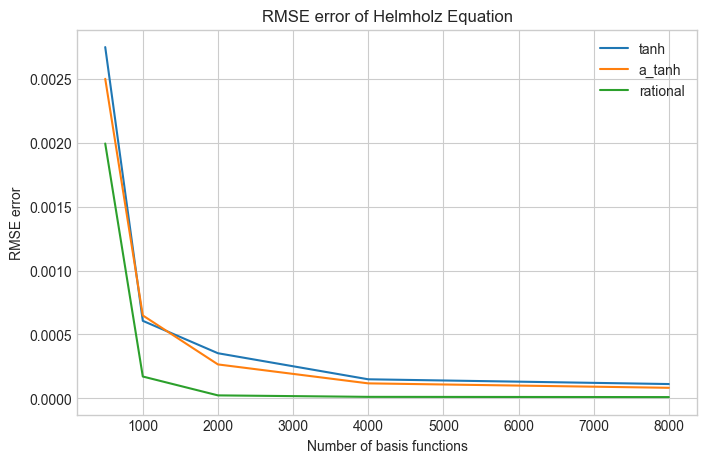

In [3]:
import pandas as pd
df = pd.read_csv("results/helmholz_results.csv")
df = df.groupby(["activation", "n_inner", "(s_1, s_2)", "k"]).agg(rmse=("rmse", "mean"),
                                                                  rel_l2=("rel_l2", "mean"),
                                                                  time=("time", "mean")).reset_index()
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 5))

n_bases_np = np.asarray(n_bases)
for activation in activations:
    rmse, rel_l2 = filter_results(df, activation, n_bases_np)
    plt.plot(n_bases_np, rmse, label=activation)

plt.title("RMSE error of Helmholz Equation")
plt.xlabel("Number of basis functions")
plt.ylabel("RMSE error")
plt.legend()
plt.show()

activation        tanh
n_inner            500
(s_1, s_2)      (0, 0)
k                    0
rmse          0.002747
rmse_std      0.000289
rel_l2        0.036839
rel_l2_std    0.003881
time          0.875667
time_std      0.203106
Name: 40, dtype: object
activation        tanh
n_inner           1000
(s_1, s_2)      (0, 0)
k                    0
rmse          0.000607
rmse_std      0.000432
rel_l2        0.008138
rel_l2_std    0.005798
time          1.717557
time_std      0.014804
Name: 41, dtype: object
activation        tanh
n_inner           2000
(s_1, s_2)      (0, 0)
k                    0
rmse          0.000353
rmse_std      0.000137
rel_l2        0.004739
rel_l2_std     0.00184
time          5.728813
time_std      0.580238
Name: 42, dtype: object
activation         tanh
n_inner            4000
(s_1, s_2)       (0, 0)
k                     0
rmse            0.00015
rmse_std       0.000035
rel_l2         0.002007
rel_l2_std     0.000472
time          25.089239
time_std       0.09395

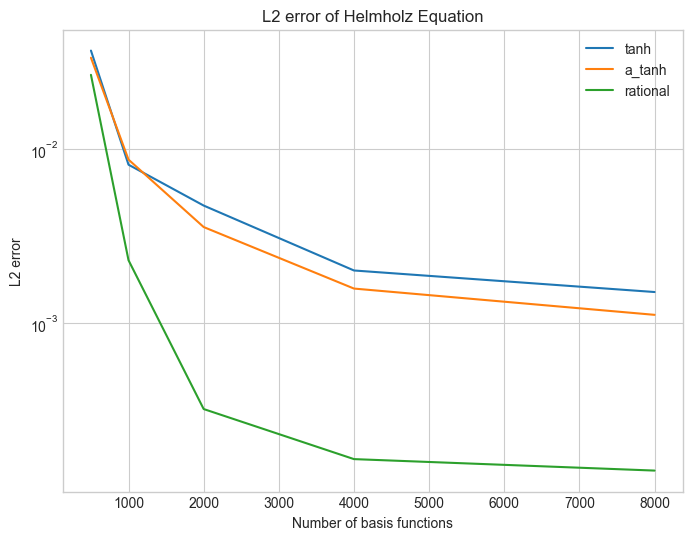

In [14]:
import pandas as pd
df = pd.read_csv("results/helmholz_results.csv")
df = df.groupby(["activation", "n_inner", "(s_1, s_2)", "k"]).agg(rmse=("rmse", "mean"),
                                                                  rmse_std=("rmse", "std"),
                                                                  rel_l2=("rel_l2", "mean"),
                                                                  rel_l2_std=("rel_l2", "std"),
                                                                  time=("time", "mean"),
                                                                  time_std=("time", "std")).reset_index()
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))

n_bases_np = np.asarray(n_bases)
for activation in activations:
    rmse, rel_l2 = filter_results(df, activation, n_bases_np)
    plt.plot(n_bases_np, rel_l2, label=activation)

plt.title("L2 error of Helmholz Equation")
plt.xlabel("Number of basis functions")
plt.ylabel("L2 error")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()